<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/WISDM_auto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam
import seaborn as sns

In [30]:
path = '/content/drive/MyDrive/Colab Notebooks/WISDM.csv'

# 1열이 인덱스처럼 보이니까 일단 다 읽고 첫 열을 버리자
raw = pd.read_csv(path, header=None)

# 첫 열이 0,1,2,... 이면 이렇게 날려
df = raw.iloc[:, 1:].copy()

# 이제 컬럼 이름 붙이기 (subject, activity, timestamp, x, y, z)
df.columns = ['subject', 'activity', 'timestamp', 'x', 'y', 'z']

df.head()

,subject,activity,timestamp,x,y,z
0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164


In [31]:
print(df['activity'].value_counts())

activity
Walking       406775
Jogging       325975
Upstairs      118589
Downstairs     97813
Sitting        54876
Standing       44547
Name: count, dtype: int64


In [32]:
#두 개만 남기고 인코딩
TARGET_NORMAL = 'Jogging'
TARGET_ABNORMAL = 'Sitting'

df2 = df[df['activity'].isin([TARGET_NORMAL, TARGET_ABNORMAL])].copy()

# 인코딩
label_map = {
    TARGET_NORMAL: 0,
    TARGET_ABNORMAL: 1
}
df2['label'] = df2['activity'].map(label_map)

df2.head()

,subject,activity,timestamp,x,y,z,label
0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953,0
1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424,0
2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722,0
3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717,0
4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164,0


In [33]:
df2 = df2.drop(columns=['timestamp', 'subject', 'activity'])
# 남는 건 x, y, z, label
df2.head()

,x,y,z,label
0,-0.694638,12.680544,0.503953,0
1,5.012288,11.264028,0.953424,0
2,4.903325,10.882658,-0.081722,0
3,-0.612916,18.496431,3.023717,0
4,-1.184970,12.108489,7.205164,0


In [34]:
# train / test 나누기
X = df2.drop(columns=['label'])
y = df2['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [35]:
#스케일링

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)


In [36]:
X_train_normal = X_train_s[y_train == 0]

input_dim = X_train_normal.shape[1]   # 여기선 3 (x,y,z)
encoding_dim = 12

inp = Input(shape=(input_dim,))
e = Dense(encoding_dim, activation='relu')(inp)
e = Dense(encoding_dim // 2, activation='relu')(e)
e = Dense(encoding_dim // 4, activation='relu')(e)
d = Dense(encoding_dim // 2, activation='relu')(e)
out = Dense(input_dim, activation='sigmoid')(d)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer=Adam(0.001), loss='mse')

autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 12)             │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 6)              │            78 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 3)              │            21 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 3)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 192 (768.00 B)

 Trainable params: 192 (768.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0326 - val_loss: 0.0099
Epoch 2/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 3/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 9.7258e-04 - val_loss: 6.6676e-04
Epoch 4/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.0732e-04 - val_loss: 5.0430e-04
Epoch 5/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7870e-04 - val_loss: 4.4505e-04
Epoch 6/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.2311e-04 - val_loss: 3.6146e-04
Epoch 7/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.4001e-04 - val_loss: 3.0360e-04
Epoch 8/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.9795e-04 - val_loss: 2.8413e-04
Epoch 9/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 2.8176e-04 - val_loss: 2.7392e-04
Epoch 10/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.7456e-04 - val_loss: 2.6872e-04
Epoch 11/100
917/917 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.6

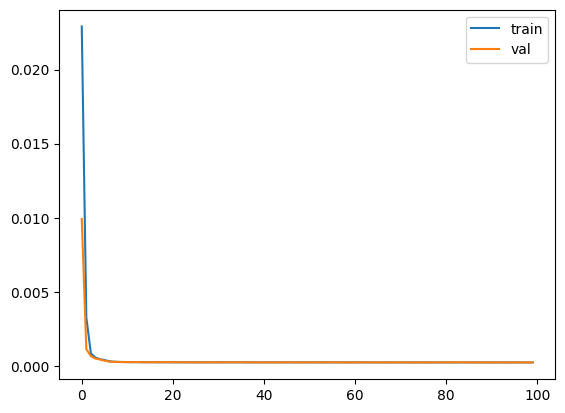

In [37]:
# 학습
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','val'])
plt.show()

In [38]:
# 테스트셋으로 재구성 오차 계산 + 임계값
pred = autoencoder.predict(X_test_s)
mse = np.mean(np.power(X_test_s - pred, 2), axis=1)

error_df = pd.DataFrame({
    'reconstruction_error': mse,
    'true_class': y_test.values
})

# 정상 샘플의 상위 99.5% 값을 임계값으로 써보자
low_threshold = error_df[error_df.true_class == 0]['reconstruction_error'].quantile(0.05)
print("low_threshold:", low_threshold)

2381/2381 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
low_threshold: 1.806841568480946e-05


low_threshold: 1.806841568480946e-05


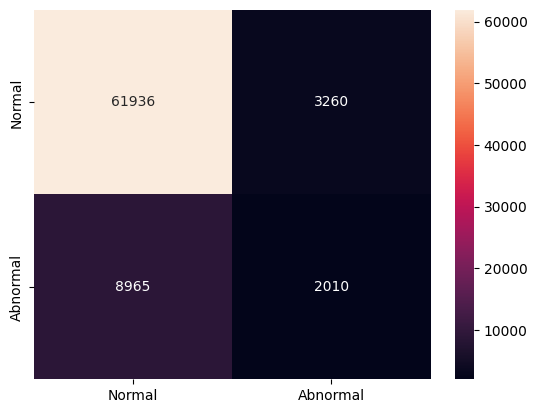

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     65196
           1       0.38      0.18      0.25     10975

    accuracy                           0.84     76171
   macro avg       0.63      0.57      0.58     76171
weighted avg       0.80      0.84      0.81     76171



In [39]:
# 평가
from sklearn.metrics import confusion_matrix, classification_report

# 정상(조깅) 오차 분포의 "아래쪽"을 기준으로 삼는다
low_threshold = error_df[error_df.true_class == 0]['reconstruction_error'].quantile(0.05)
print("low_threshold:", low_threshold)

# 오차가 너무 작은 애들을 이상으로 본다
y_pred = (error_df.reconstruction_error < low_threshold).astype(int)

cm = confusion_matrix(error_df.true_class, y_pred)
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=['Normal','Abnormal'],
            yticklabels=['Normal','Abnormal'])
plt.show()

print(classification_report(error_df.true_class, y_pred))

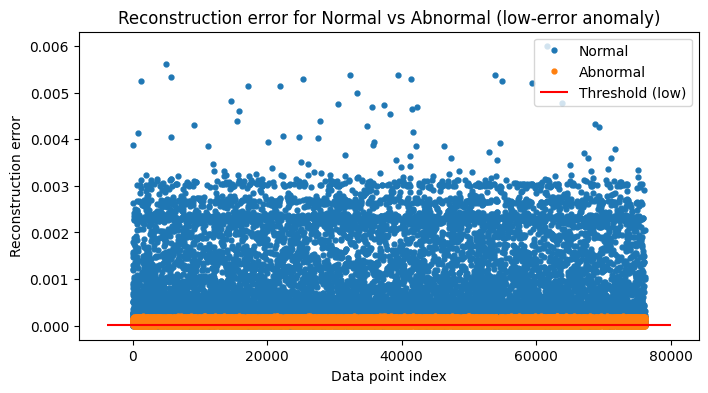

In [40]:
# ====== 산점도(오차 분포 시각화) ======
groups = error_df.groupby('true_class')
fig, ax = plt.subplots(figsize=(8,4))

for name, group in groups:
    ax.plot(group.index,
            group.reconstruction_error,
            marker='o', ms=3.5, linestyle='',
            label='Abnormal' if name == 1 else 'Normal')

ax.hlines(low_threshold,
          ax.get_xlim()[0],
          ax.get_xlim()[1],
          colors='r', zorder=100, label='Threshold (low)')
ax.legend()
plt.title("Reconstruction error for Normal vs Abnormal (low-error anomaly)")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show()

